## Install Libraries and Load Packages

In [1]:
#Install libraries
!pip install -q -U datasets
# !pip install -q -U transformers
# !pip install -q -U huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", wh

In [2]:
#Import packages
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import json
from datasets import Dataset, DatasetDict, load_dataset
# from transformers import AutoTokenizer
# from huggingface_hub import notebook_login


In [ ]:
#Log in to huggingface

notebook_login()

In [3]:
#Mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Dataset & Define Useful Functions

In [4]:
#Load Pira 2.0 dataset
mcqa = load_dataset("paulopirozelli/pira", "mcqa", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1798 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/225 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/227 [00:00<?, ? examples/s]

In [ ]:
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3")
climategpt7_tokenzier = AutoTokenizer.from_pretrained("eci-io/climategpt-7b")
climategpt13_tokenizer =  AutoTokenizer.from_pretrained("eci-io/climategpt-13b")

tokenizer_config.json:   0%|          | 0.00/137k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.54k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.54k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

In [ ]:
#Reformat input into correct json format for Mistral Models

def reformat_data(data_points):
  formatted_data = []
  for data in data_points:
    context = data['text']
    question = data['question']

    # Constructing the formatted output
    formatted_input = f'''[INST]
                        ### Instruction: Answer the question based on the provided context.
                        ### Context: {context}
                        ### Question: {question}
                        [/INST]
                        ### Answer: '''
    formatted_data.append(formatted_input)

  return formatted_data

In [ ]:
# Format Input for Mistral
formatted_train_data = reformat_data(mcqa['train'])
formatted_test_data = reformat_data(mcqa['test'])

In [ ]:
#Tokenize Input for Mistral

mistral_token_len = []
for i in range(len(formatted_test_data)):
  eval_prompt = formatted_test_data[i]
  model_input = mistral_tokenizer(eval_prompt, return_tensors="pt").to("cuda")
  input_len = len(model_input['input_ids'][0].tolist())
  mistral_token_len.append(input_len)

In [ ]:
#Tokenize for ClimateGPT

climategpt_token_len = []
for i in range(len(formatted_test_data)):
  eval_prompt = formatted_test_data[i]
  model_input = mistral_tokenizer(eval_prompt, return_tensors="pt").to("cuda")
  input_len = len(model_input['input_ids'][0].tolist())
  climategpt_token_len.append(input_len)

In [ ]:
#Define test labels
test_questions = mcqa['test']['question']
test_labels = mcqa['test']['correct']

In [5]:
#Load JSON file

def load_json_as_list_of_strings(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Ensure that the data is a list of strings
    if isinstance(data, list) and all(isinstance(item, str) for item in data):
        return data
    else:
        raise ValueError("The JSON file does not contain a list of strings")

In [6]:
# Load model output

mistrali_bl = load_json_as_list_of_strings('/content/gdrive/MyDrive/mistral_instruct_baseline_output2')
climategpt7_bl = load_json_as_list_of_strings('/content/gdrive/MyDrive/climategpt_baseline_output2')
climategpt13_bl = load_json_as_list_of_strings('/content/gdrive/MyDrive/climategpt_13B_baseline_output2')
ft_mistrali_05 = load_json_as_list_of_strings('/content/gdrive/MyDrive/ft_mistralinstruct_output2_05')
ft_mistrali_1 = load_json_as_list_of_strings('/content/gdrive/MyDrive/ft_mistralinstruct_output2_1')
ft_mistrali_2 = load_json_as_list_of_strings('/content/gdrive/MyDrive/ft_mistralinstruct_output2_2')

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_string_lengths_distribution(*lists_of_strings):
    """
    Plots a distribution curve showing the length of strings for each list of strings provided.

    Args:
    *lists_of_strings: Multiple lists of strings.
    """
    list_of_labels = ["Mistral Instruct",
                      "ClimateGPT7",
                      "ClimateGPT13",
                      "CliMistral 1%"]
    plt.figure(figsize=(10, 6))  # Set the figure size

    for i, string_list in enumerate(lists_of_strings, start=1):
        lengths = [len(s) for s in string_list]  # Calculate lengths of each string in the list
        sns.kdeplot(lengths, label=f'{list_of_labels[i-1]}', bw_adjust=0.5)  # Plot the KDE for each list

    plt.title('Distribution of Model Output Lengths')
    plt.xlabel('Length of Output Strings')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Load model scores

def load_json_scores(file_path):
  with open(file_path, 'r') as json_file:
      scores_dict = json.load(json_file)

  # Extract the values into separate lists
  rouge1_scores = scores_dict['rouge1']
  rouge2_scores = scores_dict['rouge2']
  rougeL_scores = scores_dict['rougeL']
  bertscore_scores = scores_dict['f1_bertscores']

  return rouge1_scores, rouge2_scores, rougeL_scores, bertscore_scores


In [ ]:
mistibl_roug1, mistibl_rouge2, mistibl_rougeL, mistibl_bertscore = load_json_scores('/content/gdrive/MyDrive/mistral_instruct_baseline_scores')
clim7_roug1, clim7_rouge2, clim7_rougeL, clim7_bertscore = load_json_scores('/content/gdrive/MyDrive/climategpt_baseline_scores')
clim13_roug1, clim13_rouge2, clim13_rougeL, clim13_bertscore = load_json_scores('/content/gdrive/MyDrive/climategpt_13B_baseline_scores')
mistft5_roug1, mistft5_rouge2, mistft5_rougeL, mistft5_bertscore = load_json_scores('/content/gdrive/MyDrive/mistral_finetune_.5_scores')
mistft1_roug1, mistft1_rouge2, mistft1_rougeL, mistft1_bertscore = load_json_scores('/content/gdrive/MyDrive/mistral_finetune_1_scores')
mistft2_roug1, mistft2_rouge2, mistft2_rougeL, mistft2_bertscore = load_json_scores('/content/gdrive/MyDrive/mistral_finetune_2_scores')

In [ ]:
# Plot tokenized input length vs BERTScore

def plot_tokenized_len(model_name, input_len, bertscore_scores):
  plt.scatter(input_len, bertscore_scores, color='blue')

  # Add labels and title
  plt.xlabel('Tokenized Input Length')
  plt.ylabel('BERTScore')
  plt.title(f'{model_name}: Tokenized Input Length vs BERTScore')
  plt.legend()

  # Show the plot
  plt.show()

In [ ]:
# Identify data point with min and max score

def find_min_max_indices(list1, list2):
    combined_list = list(zip(list1, list2))

    # Find the max and min tuples
    max_tuple = max(combined_list, key=lambda x: (x[0], x[1]))
    min_tuple = min(combined_list, key=lambda x: (x[0], x[1]))

    # Find all indices of max and min tuples
    max_indices = [i for i, tup in enumerate(combined_list) if tup == max_tuple]
    min_indices = [i for i, tup in enumerate(combined_list) if tup == min_tuple]

    print("Max indices:", max_indices)
    print("Min indices:", min_indices)

In [ ]:
def find_special_index(list1, list2):
    # Create a combined list of tuples
    combined_list = list(zip(list1, list2))

    # Filter the list to only include tuples where the first element is zero
    filtered_tuples = [(i, tup) for i, tup in enumerate(combined_list) if tup[0] == 0]

    if not filtered_tuples:
        print("No tuples with a zero in the first element found.")
        return None

    # Find the tuple with the maximum second element among the filtered tuples
    max_tuple = max(filtered_tuples, key=lambda x: x[1][1])

    # Get the index and the tuple
    max_index, max_value_tuple = max_tuple

    print("Index:", max_index)
    print("Tuple:", max_value_tuple)


##Compare output length for each model

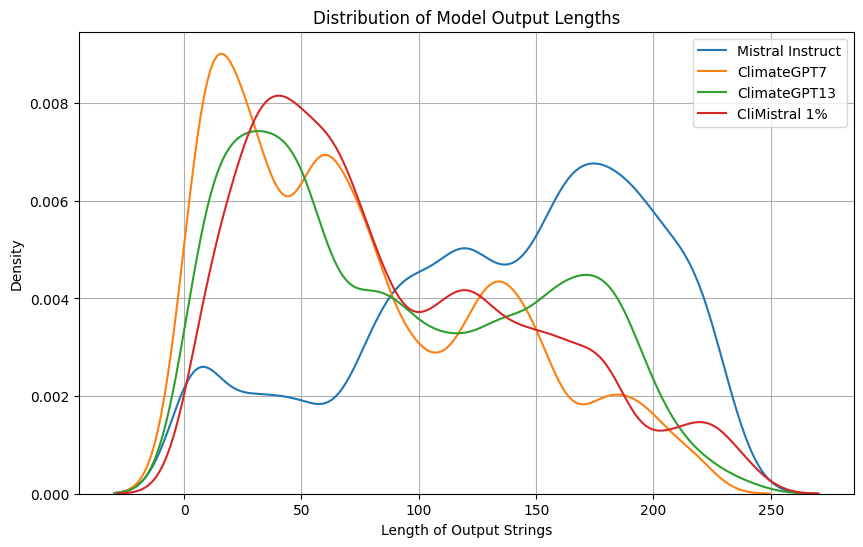

In [23]:
plot_string_lengths_distribution(mistrali_bl,
                                 climategpt7_bl,
                                 climategpt13_bl,
                                 ft_mistrali_1)

##Evaluate relationship between ROUGE and BERTSCore

In [ ]:
# Plot best fit line for ROUGE-L score versus BERTScore
def plot_best_fit_lines(data_sets):
    plt.figure(figsize=(10, 6))

    for i, (model_name, rougeL_scores, bertscore_scores) in enumerate(data_sets):
        # Convert scores to numpy arrays
        X = np.array(rougeL_scores).reshape(-1, 1)
        y = np.array(bertscore_scores)

        # Perform linear regression to find the line of best fit
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X)

        # Plot the line of best fit
        plt.plot(rougeL_scores, y_pred, label=f'{model_name}')

    # Add labels and title
    plt.xlabel('ROUGE-L Score')
    plt.ylabel('BERTScore')
    plt.title('ROUGE-L Score vs BERTScore: Best Fit Lines')
    plt.legend()

    # Show the plot
    plt.show()

# Example usage with multiple data sets
data_sets = [
    ('Model 1', [0.3, 0.4, 0.5, 0.6], [0.35, 0.45, 0.55, 0.65]),
    ('Model 2', [0.2, 0.5, 0.7], [0.25, 0.5, 0.7]),
    ('Model 3', [0.4, 0.5, 0.6, 0.8], [0.4, 0.6, 0.65, 0.8])
]



In [ ]:
data_sets = [
    ('Mistral Instruct', mistibl_rougeL, mistibl_bertscore),
    ('ClimateGPT 7B', clim7_rougeL, clim7_bertscore),
    ('ClimateGPT 13B', clim13_rougeL, clim13_bertscore),
    ('CliMistral 0.5%', mistft5_rougeL, mistft5_bertscore),
    ('CliMistral 1%', mistft1_rougeL, mistft1_bertscore),
    ('CliMistral 2%', mistft2_rougeL, mistft2_bertscore)
]

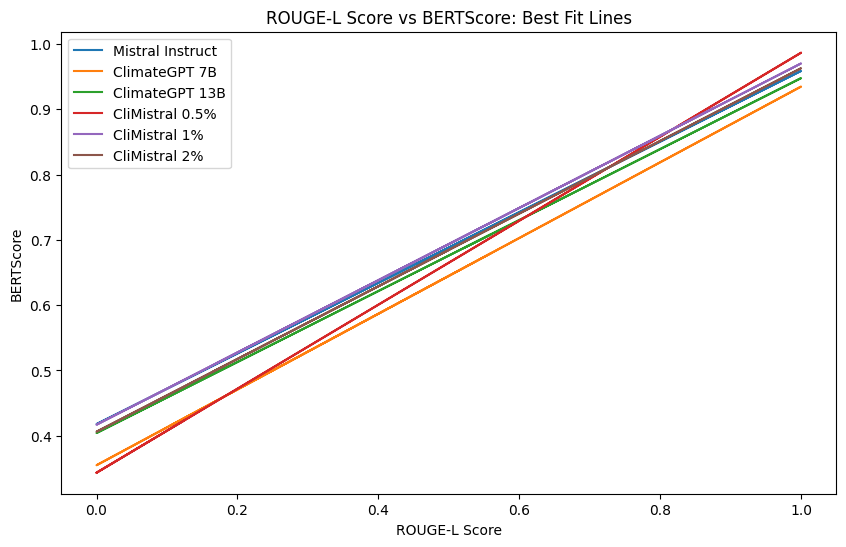

In [ ]:
plot_best_fit_lines(data_sets)

##Evaluate which samples received the lowest and highest scores for each model and evaluate relationship between tokenized input length and BERTScore

In [ ]:
find_min_max_indices(mistibl_rougeL, mistibl_bertscore)
find_special_index(mistibl_rougeL, mistibl_bertscore)

Max indices: [4, 10, 37, 56, 128, 160, 185]
Min indices: [5]
Index: 89
Tuple: (0.0, 0.5007250905036926)


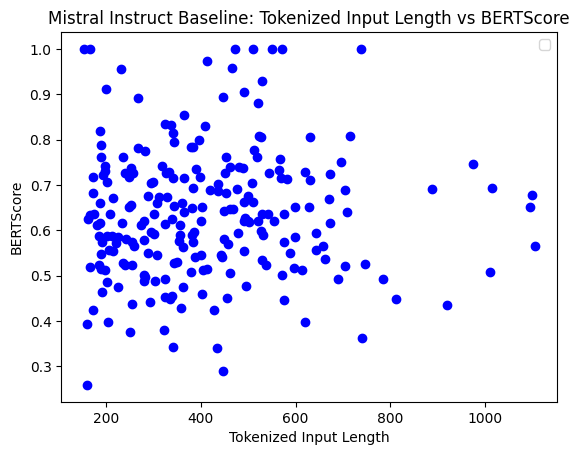

In [ ]:
plot_tokenized_len('Mistral Instruct Baseline', mistral_token_len, mistibl_bertscore)

In [ ]:
find_min_max_indices(clim7_rougeL, clim7_bertscore)
find_special_index(clim7_rougeL, clim7_bertscore)

Max indices: [3, 10, 38, 138, 174, 179]
Min indices: [15, 26, 118, 159, 192]
Index: 210
Tuple: (0.0, 0.6918102502822876)


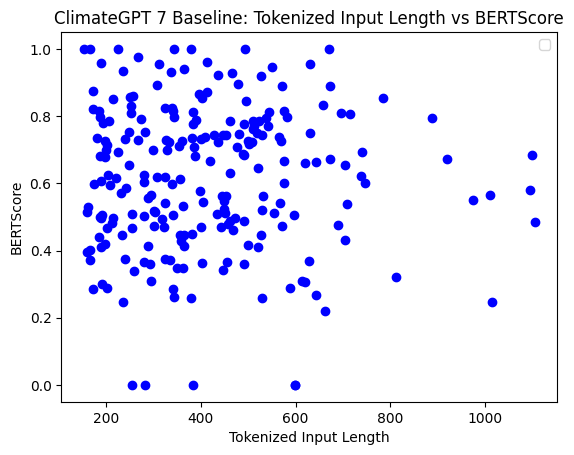

In [ ]:
plot_tokenized_len('ClimateGPT 7 Baseline', climategpt_token_len, clim7_bertscore)

In [ ]:
find_min_max_indices(clim13_rougeL, clim13_bertscore)
find_special_index(clim13_rougeL, clim13_bertscore)

Max indices: [154]
Min indices: [84]
Index: 210
Tuple: (0.0, 0.5749403238296509)


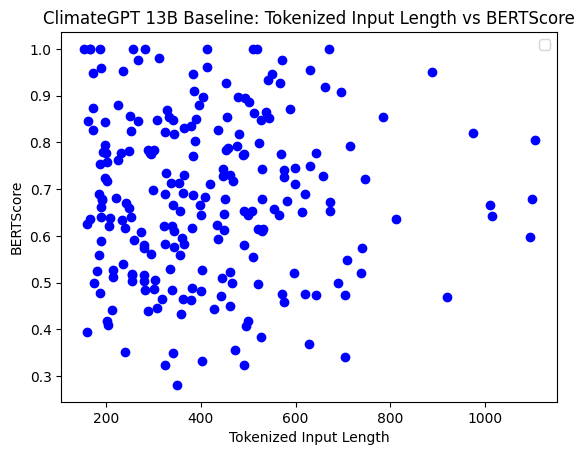

In [ ]:
plot_tokenized_len('ClimateGPT 13B Baseline', climategpt_token_len, clim13_bertscore)

In [ ]:
find_min_max_indices(mistft5_rougeL, mistft5_bertscore)
find_special_index(mistft5_rougeL, mistft5_bertscore)

Max indices: [96]
Min indices: [1, 12, 56, 70, 136, 161, 186, 201, 210, 226]
Index: 89
Tuple: (0.0, 0.5010749101638794)


In [ ]:
find_min_max_indices(mistft1_rougeL, mistft1_bertscore)
find_special_index(mistft1_rougeL, mistft1_bertscore)

Max indices: [75, 96, 157, 174, 203]
Min indices: [154]
Index: 8
Tuple: (0.0, 0.6108269095420837)


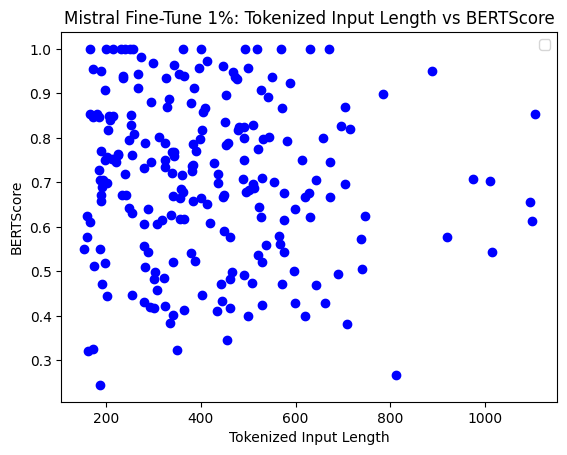

In [ ]:
plot_tokenized_len('Mistral Fine-Tune 1%', mistral_token_len, mistft1_bertscore)

In [ ]:
find_min_max_indices(mistft2_rougeL, mistft2_bertscore)
find_special_index(mistft2_rougeL, mistft2_bertscore)

Max indices: [75, 217]
Min indices: [221]
Index: 8
Tuple: (0.0, 0.6330411434173584)


##Compare Generated Outputs

In [ ]:
def print_output(index):
  print(f'''Question: {test_questions[index]}
            Label: {test_labels[index]}
            Mistral Instruct BL: {mistrali_bl[index]}, Rouge-L: {mistibl_rougeL[index]:.2f}, BERTScore: {mistibl_bertscore[index]:.2f}
            ClimateGPT7 BL: {climategpt7_bl[index]}, Rouge-L: {clim7_rougeL[index]:.2f}, BERTScore: {clim7_bertscore[index]:.2f}
            ClimateGPT13 BL: {climategpt13_bl[index]}, Rouge-L: {clim13_rougeL[index]:.2f}, BERTScore: {clim13_bertscore[index]:.2f}
            Mistral Instruct FT 0.5%: {ft_mistrali_05[index]}, Rouge-L: {mistft5_rougeL[index]:.2f}, BERTScore: {mistft5_bertscore[index]:.2f}
            Mistral Instruct FT 1%: {ft_mistrali_1[index]}, Rouge-L: {mistft1_rougeL[index]:.2f}, BERTScore: {mistft1_bertscore[index]:.2f}
            Mistral Instruct FT 2%: {ft_mistrali_2[index]}, Rouge-L: {mistft2_rougeL[index]:.2f}, BERTScore: {mistft2_bertscore[index]:.2f}
        ''')

In [ ]:
print_output(210)

Question: How much more CO2 is being emited in 2019 compared to 2010, in gigaton? 
            Label: 2.9.
            Mistral Instruct BL: 33.3 gigatons in 2019, which is an increase of approximately 3 gigatons compared to 2010., Rouge-L: 0.00, BERTScore: 0.36
            ClimateGPT7 BL: 30.7, Rouge-L: 0.00, BERTScore: 0.69
            ClimateGPT13 BL: 10.3 gigatons., Rouge-L: 0.00, BERTScore: 0.57
            Mistral Instruct FT 0.5%: , Rouge-L: 0.00, BERTScore: 0.00
            Mistral Instruct FT 1%: 3.3 gigatons, Rouge-L: 0.00, BERTScore: 0.51
            Mistral Instruct FT 2%: 3.3 gigatons, Rouge-L: 0.00, BERTScore: 0.51
        


In [ ]:
print_output(8)

Question: Whose history and development is showcased on "BRAZIL FURTHERS ITS LEADERSHIP IN DEEPWATER E&P"? 
            Label: Petrobrás and its various offshore operations.
            Mistral Instruct BL: The history and development of Petrobrás is showcased in "Brazil Furthers Its Leadership In Deepwater E&P"., Rouge-L: 0.24, BERTScore: 0.52
            ClimateGPT7 BL: Petrobrás[/SYS]][/INST>[/SYS]][/INST>[/SYS]][/INST>[/, Rouge-L: 0.27, BERTScore: 0.37
            ClimateGPT13 BL: Petrobrás., Rouge-L: 0.44, BERTScore: 0.64
            Mistral Instruct FT 0.5%: Instruction  the question based on the provided context.                          Context The deepwater E&P technology used in Brazil for deepwater drilling which has made, Rouge-L: 0.00, BERTScore: 0.40
            Mistral Instruct FT 1%: Petrobras', Rouge-L: 0.00, BERTScore: 0.61
            Mistral Instruct FT 2%: Petrobras, Rouge-L: 0.00, BERTScore: 0.63
        


In [ ]:
print_output(75)

Question: Where will the main socioeconomic impacts of changes in erosion and sedimentation occur?
            Label: At locations where erosion coincides with high population density.
            Mistral Instruct BL: Main socioeconomic impacts of changes in erosion and sedimentation will occur at locations where erosion coincides with high population density. This includes areas adjacent to the Ganges,, Rouge-L: 0.50, BERTScore: 0.71
            ClimateGPT7 BL: Locations where erosion coincides with high population density., Rouge-L: 0.94, BERTScore: 0.95
            ClimateGPT13 BL: locations where erosion coincides with high population density., Rouge-L: 0.94, BERTScore: 0.95
            Mistral Instruct FT 0.5%: Instruction  the question based on the provided context.                          Context Changes in impact Coastal erosion and changes in sedimentation pose severe risks to, Rouge-L: 0.06, BERTScore: 0.48
            Mistral Instruct FT 1%: At locations where erosion coinc

In [ ]:
print_output(154)

Question: What percentage of the current Brazilian oil production does the Campos basin correspond to?
            Label: 62%.
            Mistral Instruct BL: 62%, Rouge-L: 1.00, BERTScore: 0.82
            ClimateGPT7 BL: about 62%, Rouge-L: 0.67, BERTScore: 0.68
            ClimateGPT13 BL: 62%., Rouge-L: 1.00, BERTScore: 1.00
            Mistral Instruct FT 0.5%: Instruction  the question based on the provided context.                          Context In 1939, the Lobito oil field, Brazil's first, Rouge-L: 0.00, BERTScore: 0.28
            Mistral Instruct FT 1%: ### Context: In 1939, the Lobito oil field, Brazil's first, was discovered. During the 1950's,, Rouge-L: 0.00, BERTScore: 0.24
            Mistral Instruct FT 2%: 62%, Rouge-L: 1.00, BERTScore: 0.82
        


In [ ]:
print_output(221)

Question: When did the first installation of an Electric Submersible Pump take place in an underwater well?
            Label: October/1994.
            Mistral Instruct BL: The first installation of an Electric Submersible Pump took place in an underwater well in October 1994., Rouge-L: 0.21, BERTScore: 0.38
            ClimateGPT7 BL: October / 1994, Rouge-L: 1.00, BERTScore: 0.86
            ClimateGPT13 BL: October/1994, Rouge-L: 1.00, BERTScore: 0.86
            Mistral Instruct FT 0.5%: Instruction  the question based on the provided context.                          Context As offshore oil fields are being developed towards deeper and deeper waters, new technologies are required, Rouge-L: 0.00, BERTScore: 0.27
            Mistral Instruct FT 1%: October/1994., Rouge-L: 1.00, BERTScore: 1.00
            Mistral Instruct FT 2%: As offshore oil fields are being developed towards deeper and deeper waters, new technologies are required to curb capital expenditures. In Brazil, where o